In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim
from tqdm.auto import tqdm
from sklearn.manifold import MDS

import multitask.dataset as dataset
from multitask.models.task_switching import get_task_model
import multitask.models.task_switching.utils as utils
import multitask.models.task_switching.hooks as hooks
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
sns.set_theme(style='ticks', palette='pastel')
mpl.rcParams['font.family'] = 'Liberation Sans'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure = os.path.join('svg', 'figure03b_mds_contexts_removed.svg')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = list(range(len(num_hidden)))  # [0]

# For generating the plots for removed change the line below:
# task_switching_tasks[task_name]['activations'][i_context] = 1
# and set the value to 0

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_02_23_14)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [7]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [12]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = None  # Set to 0 for Removed, 1 for all and first
    assert task_switching_tasks[task_name]['activations'][i_context] is not None, 'Set the value for all, first or removed!'

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [0, 0]
value: [0, 0]


In [10]:
device = get_device()
criterion = nn.CrossEntropyLoss()

seeds_task_swithing  = sorted(list(results_task_switching.keys()))
list_activations = []
list_numbers = []

for i_seed, seed in tqdm(enumerate(seeds_task_swithing), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)
    
    list_activations.append(activations)
    list_numbers.append(numbers)

  0%|          | 0/10 [00:00<?, ?it/s]

Running on GPU.


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


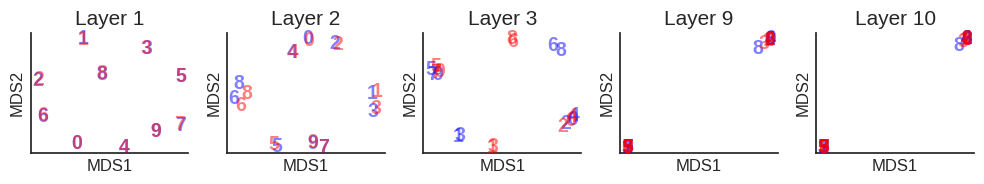

In [ ]:
idx_run_activations = 9  # For plotting purposes 
idxs_layers = [0, 1, 2, 8, 9]  # Layers to show in the plots
num_layers_plot = len(idxs_layers)

# Assemble activations_matrix
run_activations = list_activations[idx_run_activations]
labels_test = list_numbers[idx_run_activations]

fig, ax = plt.subplots(1, num_layers_plot, figsize=(2 * num_layers_plot, 2))

for i_layer, idx_layer in enumerate(idxs_layers):
    num_units = num_hidden[idx_layer]
    layer = f'layer{idx_layer+1}'

    for i_task, task in enumerate(tasks_names):
        activations = run_activations[task][layer]
        mean_activations = np.zeros((10, num_units))

        for i_number, number in enumerate(range(10)):
            mean_activations[number, :] = activations[labels_test == number, :].mean(axis=0)        

        if i_task == 0:
            mean_activations_tasks = mean_activations
        else:
            mean_activations_tasks = np.vstack((mean_activations_tasks, mean_activations))

    dissimilarity = (1 - np.corrcoef(mean_activations_tasks, rowvar=True)) / 2

    mds_2dim = MDS(n_components=2,
               metric=True,
               dissimilarity='precomputed',
               random_state=4321,
               max_iter=1000,
               n_init=20,
               eps=1e-5)
    mds_activations = mds_2dim.fit_transform(dissimilarity)

    mds_parity = mds_activations[:10, :]
    mds_value = mds_activations[10:, :]
    
    ax[i_layer].scatter(mds_activations[:, 0], mds_activations[:, 1], alpha=0)

    for number in range(10):
        ax[i_layer].text(mds_parity[number, 0], mds_parity[number, 1], number, ha='center', va='center', color='blue', fontsize=14, weight='bold', alpha=0.5)

    for number in range(10):
        ax[i_layer].text(mds_value[number, 0], mds_value[number, 1], number, ha='center', va='center', color='red', fontsize=14, weight='bold', alpha=0.5)

    ax[i_layer].set_xlabel('MDS1', fontsize=12)
    ax[i_layer].set_ylabel('MDS2', fontsize=12)
    ax[i_layer].set_title(f'Layer {idx_layer + 1}', fontsize=15)

    ax[i_layer].set_xticks([])
    ax[i_layer].set_yticks([])

fig.tight_layout()
fig.savefig(path_figure)  # Add sum to distinguish Removed
plt.show()